# Attention付きSeq2Seqを使った機械翻訳

## BSNアイネットの社内LAN用の設定
プロキシ配下でtf.keras.utils.get_file()がSSL証明書をロードできないエラーを回避するため。

In [1]:
# for BSN I-Net local only
import requests
requests.packages.urllib3.disable_warnings()
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default
    pass
else:
    # Handle target environment that doesn't support HTTPS verification
    ssl._create_default_https_context = _create_unverified_https_context

## matplotlibで日本語を表示するためのライブラリインストール

In [2]:
!pip install japanize_matplotlib

     |████████████████████████████████| 4.1 MB 521 kB/s eta 0:00:01
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120274 sha256=da1a426a918e64a2ace6d1e68f8298b6c7e4f619e5179e96975ccfcbc9a9b9f8
  Stored in directory: /Users/itagaki/Library/Caches/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib


## ライブラリのインポート

In [3]:
import os
import unicodedata
import time
import numpy as np
import pandas as pd
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import japanize_matplotlib
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

## 英日翻訳データセットのダウンロード

この演習では、小田悠介氏（現：LegalForce Research チーフリサーチャー）が公開している "small_parallel_enja" を使用します。  
このデータセットは、日英対訳コーパスとして知られている[TANAKA corpus](http://www.edrdg.org/wiki/index.php/Tanaka_Corpus)から、文長が4単語から16単語までの短い文を抽出し、トークナイザ（英語:Stanford Tokenizer/日本語:KyTea）でトークナイズしたデータセットです。  
下記のコードでは、`tf.keras.utils.get_file()`を使ってGitHubからZIPファイルをダウンロードして展開し、展開されたディレクトリの内容を確認しています。

In [4]:
URL = 'https://github.com/odashi/small_parallel_enja/archive/master.zip'

zip_file_path = get_file('small_parallel_enja.zip', URL, cache_subdir='small_parallel_enja', extract=True) 

data_dir = os.path.join(os.path.dirname(zip_file_path), 'small_parallel_enja-master')

!ls -l $data_dir

total 20784
-rw-r--r--  1 itagaki  staff     1946  2 12 16:00 README.md
-rw-r--r--  1 itagaki  staff    17054  2 12 16:00 dev.en
-rw-r--r--  1 itagaki  staff    27781  2 12 16:00 dev.ja
-rw-r--r--  1 itagaki  staff    17301  2 12 16:00 test.en
-rw-r--r--  1 itagaki  staff    27793  2 12 16:00 test.ja
-rw-r--r--  1 itagaki  staff  1701356  2 12 16:00 train.en
-rw-r--r--  1 itagaki  staff   339768  2 12 16:00 train.en.000
-rw-r--r--  1 itagaki  staff   340186  2 12 16:00 train.en.001
-rw-r--r--  1 itagaki  staff   341174  2 12 16:00 train.en.002
-rw-r--r--  1 itagaki  staff   339953  2 12 16:00 train.en.003
-rw-r--r--  1 itagaki  staff   340275  2 12 16:00 train.en.004
-rw-r--r--  1 itagaki  staff    30025  2 12 16:00 train.en.vocab.4k
-rw-r--r--  1 itagaki  staff    51162  2 12 16:00 train.en.vocab.all
-rw-r--r--  1 itagaki  staff  2784447  2 12 16:00 train.ja
-rw-r--r--  1 itagaki  staff   556444  2 12 16:00 train.ja.000
-rw-r--r--  1 itagaki  staff   555732  2 12 16:00 train.ja.001
-r

## 訓練用データの読み込み

small_parallel_enjaデータセットでは、訓練用のデータが50,000ペア含まれていますが、ここでは学習にかかる時間を短縮するため、最初の30000件のみを使用します。  

In [5]:
# 訓練時間節約のためデータの一部のみ使用する
TRAIN_SIZE_LIMIT = 30000

def load_data(path):
    texts = []
    for line in open(path, 'r'):
        texts.append(line.strip()) # 改行コードなどを除去
    return texts
  

train_en = load_data(os.path.join(data_dir, 'train.en'))
train_ja = load_data(os.path.join(data_dir, 'train.ja'))

train_en = train_en[:TRAIN_SIZE_LIMIT]
train_ja = train_ja[:TRAIN_SIZE_LIMIT]

print(train_en[:3])
print(train_ja[:3])

["i can 't tell who will arrive first .", 'many animals have been destroyed by men .', "i 'm in the tennis club ."]
['誰 が 一番 に 着 く か 私 に は 分か り ま せ ん 。', '多く の 動物 が 人間 に よ っ て 滅ぼ さ れ た 。', '私 は テニス 部員 で す 。']


## データの前処理

データの前処理を行います。今回のデータはトークナイズ済みであるため、ユニコードの表現のブレを正規化する処理と、文頭及び文末にそれぞれ目印となるトークンを追加する処理のみを行なっています。データや目的によっては、記号やHTMLタグなどの除去や大文字の小文字への変換などを行います。

In [6]:
def preprocess(text):
    text = unicodedata.normalize('NFKC', text) # ユニコード正規化
    text = '<start> ' + text + ' <end>'        # 文頭と文末を表すトークンを追加
    return text

train_input = [preprocess(s) for s in train_en]
train_target = [preprocess(s) for s in train_ja]

### 入力および出力の最大長

今回のデータセットでは、英語、日本語とも最大長は16語、これに<start>, <end>を加えた18が最大長です。 　

In [7]:
input_lengths = [len(s.split(' ')) for s in train_input]
target_lengths = [len(s.split(' ')) for s in train_target]

max_length_inp = max(input_lengths)
max_length_targ = max(target_lengths)

print('input max length:', max_length_inp)
print('target max length:', max_length_targ)

input max length: 18
target max length: 18


### トークンのベクトル化

トークンを機械学習モデルで扱えるようにベクトル化します。  
TensorFlowで使えるベクトル化モジュールには、`tf.keras.preprocessing.text.Tokenizer`などいくつかありますが、ここでは新しく開発された`tf.keras.layers.experimental.preprocessing.TextVectorization`を使用します。このクラスは、レイヤとして実装されているため、関数として使用する他に、モデルに組み込んで実行することも可能です。また、出力も今回使用するトークンを整数値にする'int'モードの他に、テキスト全体をマルチホットベクトル化する'binary'モード、単語の出現回数のベクトルにする'count'モード、TF-IDFベクトル化する'tf-idf'モードが使える他、出力の長さを揃えてパディングを行う機能も備えています。

TextVectorization()では、ボキャブラリーをファイルから直接読み込ませることもできますが、今回は訓練用データをつかって語彙の抽出を行なっています。

ベクトル化したデータは、tf.data.Datasetに変換し、input（英語）とtarget（日本語）のペアを構成するtrain_dsデータセットに加工しています。

In [8]:
en_vectorizer = TextVectorization(max_tokens=20000,
                                  standardize=None,
                                  output_mode='int',
                                  output_sequence_length=max_length_inp)

ja_vectorizer = TextVectorization(max_tokens=20000,
                                  standardize=None,
                                  output_mode='int',
                                  output_sequence_length=max_length_targ)

en_vectorizer.adapt(train_input)
ja_vectorizer.adapt(train_target)

train_input_ds = tf.data.Dataset.from_tensor_slices(en_vectorizer(train_input))
train_target_ds = tf.data.Dataset.from_tensor_slices(ja_vectorizer(train_target))

train_ds = tf.data.Dataset.zip((train_input_ds, train_target_ds))

### ボキャブラリの抽出と語彙数の計算

TextVectorizationでは、パディングに使われる0も空文字列としてボキャブラリに含まれています。

In [9]:
en_vocab = en_vectorizer.get_vocabulary()
ja_vocab = ja_vectorizer.get_vocabulary()
vocab_inp_size = len(en_vocab)
vocab_tar_size = len(ja_vocab)

print(en_vocab[:10])
print(ja_vocab[:10])

['', '[UNK]', '<start>', '<end>', '.', 'the', 'i', 'to', 'you', 'is']
['', '[UNK]', '<start>', '<end>', '。', 'は', 'い', 'に', 'た', 'を']


## サンプルデータの確認

In [10]:
def convert(vocab, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, vocab[t]))

In [11]:
en, ja = next(iter(train_ds)) # train_dsから最初のデータを取り出す

In [12]:
print ("Input Language; index to word mapping")
convert(en_vocab, en.numpy())
print ()
print ("Target Language; index to word mapping")
convert(ja_vocab, ja.numpy())

Input Language; index to word mapping
2 ----> <start>
6 ----> i
41 ----> can
22 ----> 't
149 ----> tell
136 ----> who
29 ----> will
709 ----> arrive
231 ----> first
4 ----> .
3 ----> <end>

Target Language; index to word mapping
2 ----> <start>
92 ----> 誰
14 ----> が
239 ----> 一番
7 ----> に
161 ----> 着
29 ----> く
22 ----> か
18 ----> 私
7 ----> に
5 ----> は
290 ----> 分か
39 ----> り
21 ----> ま
40 ----> せ
30 ----> ん
4 ----> 。
3 ----> <end>


## モデルの構築

Attention付きのSeq2Seqモデルは下図のような構造を持っています。

リカレントニューラルネットワーク（RNN）を使ったEncoder/Decoderモデルですが、単純なSeq2SeqモデルがDecoderの出力のみを使って次の単語を予測するのに対して、Encoderのすべての時点の状態情報と出力を使い、これにデコーダーの現在の状態を組み合わせて重み付けを行ってコンテキストベクトルを生成します。このコンテキストベクトルとデコーダーの現時点の状態を組み合わせてアテンションベクトルを計算し、このベクトルから次の単語を推定します。

1階層のアテンション付きRNNの場合、こうして学習されたアテンションの重みは、入力文の単語と、出力文の単語の関連性を学習していると言うこともできます。

![seq2seq with attation model](https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg)

from "アテンションを用いたニューラル機械翻訳 -- tensorflow.org" https://www.tensorflow.org/tutorials/text/nmt_with_attention  
original "Effective Approaches to Attention-based Neural Machine Translation, Minh-Thang Luong et al." https://arxiv.org/abs/1508.04025v5

<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_0.jpg" alt="attention equation 0" width="800">
<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_1.jpg" alt="attention equation 1" width="800">

### モデル構築に必要なパラメータ定義

In [17]:
BUFFER_SIZE = len(train_input)
BATCH_SIZE = 64
steps_per_epoch = len(train_input) // BATCH_SIZE
embedding_dim = 256
units = 1024

### 訓練用データセットの準備

`tf.data.Dataset`では、データのシャッフル`shuffle`やバッチ化`batch`を使ったメソッドチェインでデータの加工が可能です。  
サイズの大きなデータセットの場合、`prefetch`や`cache`を行うことで、高速化も期待できます。

In [18]:
dataset = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### 入力データのshapeの確認

In [19]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 18]), TensorShape([64, 18]))

### Encoderの定義

ここでは、`Embedding`レイヤと`GRU`レイヤを1つずつ使ったシンプルなエンコーダを定義します。  
`tf.keras`を使ったモデル定義の方法としては、`tf.keras.Sequential`を使う方法や、レイヤの数珠つなぎを自分で作成するFunctional APIがありますが、ここでは`tf.keras.Model`を継承したサブクラス化の手法を使用しています。
サブクラスでのモデル定義では、レイヤなどの定義を初期化メソッド（ __init__ ）でインスタンス変数を使って行い、クラスを関数として呼び出すためのcallメソッドで、順方向のデータ処理の流れを定義します。


リカレントニューラルネットワークでよく使われるのは`LSTM`ですが、ここではこれを簡略化した`GRU`を使うことで、訓練に要する時間を節約します。

単純なSeq2Seqモデルとは異なり、GRUからはシーケンスと状態を出力します。

In [15]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

### Encoderの出力shapeの確認

In [16]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# サンプル入力
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 18, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


### BahdanauAttentionの定義

代表的なAttentionの定義には、上記のようにLuongの論文で発表された内積型アテンションと、[Neural Machine Translation by Jointly Learning to Align and Translate Dzmitry Bahdanau et al.](https://arxiv.org/abs/1409.0473)で提案された加法アテンションがありますが、ここではBahdanau Attentionと呼ばれる後者の加法アテンションをtf.kerasのレイヤとして実装します。

In [17]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # スコアを計算するためにこのように加算を実行する
        hidden_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # スコアを self.V に適用するために最後の軸は 1 となる
        # self.V に適用する前のテンソルの shape は  (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
                      self.W1(values) + self.W2(hidden_with_time_axis)))

        # attention_weights の shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector の合計後の shape == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

### BahdanauAttentionの出力shapeの確認

In [18]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 18, 1)


### Decoderの定義

Decoderでは、Attentionをレイヤとして組み込み、Encoderの状態と出力を与えて、コンテキストベクトルとアテンションの重みを計算します。 　
また、Decorderの入力に、コンテキストベクトルを結合したものをGRUに渡し、その出力を全結合層に渡して次の単語を予測します。

In [19]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # アテンションのため
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # enc_output の shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # 埋め込み層を通過したあとの x の shape  == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # 結合後の x の shape == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # 結合したベクトルを GRU 層に渡す
        output, state = self.gru(x)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights

### Decoderの出力shapeの確認

In [20]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 6952)


## モデルの訓練

### 損失関数の定義

Decoderの出力は多クラス分類であるため、損失関数には`tf.keras.losses.SparseCategoricalCrossentropy`を使います。この例ではDecoder内部でsoftmax変換をかけていないので、`from_logit=True`に設定しています。また、バッチごとの損失をそのまま受け取りたいので、`reduction='none'`に設定します。


パディングされたデータで正しく損失値を計算するために、パディングからmaskを計算して計算から除外しています。

In [21]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
                             from_logits=True, reduction='none')
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

### チェックポイントの定義

In [22]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

### 訓練の実行

#### 訓練の1ステップを定義

入力データのバッチ1つずつに対応する`train_step()`関数を定義します。  
勾配計算を行うために、`with tf.GradientTape() as tape`のコンテキストでバッチの順方向処理を行います。  
訓練の効率を上げるために、前ステップでDecoderが予測したトークンではなく、教師データ（target）の該当位置のトークンを使用しています。これをTeacher Forcingと呼びます。  
順方向処理が終わったら、`tape`を使って損失の訓練可能パラメータに対する勾配を計算し、計算された勾配をオプティマイザに渡してパラメータを更新します。

この関数は`@tf.function`でアノテートし、TensorFlowの計算グラフ中で計算できるようにします。

In [23]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([ja_vocab.index('<start>')] * BATCH_SIZE, 1)

        # Teacher Forcing - 正解値を次の入力として供給
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(targ[:, t], predictions)

            # Teacher Forcing を使用
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

### 訓練ループ

訓練用データを1バッチずつ取り出し、上で定義した`train_step()`関数を使ってバッチごとの損失からエポックごとの損失を計算して経過時間とともに表示します。  
この例では、100バッチごとに損失を表示し、また、2エポックごとにチェックポイントの保存を行なっています。  
validationデータを使用する場合には、エポックごと、あるいは定義したエポック感覚でvalidation lossを計算することもできます。その際には、勾配計算とパラメータ更新は行なってはいけません。

In [24]:
EPOCHS = 20

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
              print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
    # 2 エポックごとにモデル（のチェックポイント）を保存
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 6.1205
Epoch 1 Batch 100 Loss 2.6564
Epoch 1 Batch 200 Loss 2.3286
Epoch 1 Batch 300 Loss 2.2678
Epoch 1 Batch 400 Loss 2.2476
Epoch 1 Loss 2.5152
Time taken for 1 epoch 54.825743436813354 sec

Epoch 2 Batch 0 Loss 1.8989
Epoch 2 Batch 100 Loss 1.9250
Epoch 2 Batch 200 Loss 1.8727
Epoch 2 Batch 300 Loss 1.8464
Epoch 2 Batch 400 Loss 1.8113
Epoch 2 Loss 1.8795
Time taken for 1 epoch 36.00258159637451 sec

Epoch 3 Batch 0 Loss 1.5908
Epoch 3 Batch 100 Loss 1.7378
Epoch 3 Batch 200 Loss 1.7886
Epoch 3 Batch 300 Loss 1.6569
Epoch 3 Batch 400 Loss 1.5471
Epoch 3 Loss 1.6218
Time taken for 1 epoch 35.02392625808716 sec

Epoch 4 Batch 0 Loss 1.3151
Epoch 4 Batch 100 Loss 1.3490
Epoch 4 Batch 200 Loss 1.3743
Epoch 4 Batch 300 Loss 1.2452
Epoch 4 Batch 400 Loss 1.2473
Epoch 4 Loss 1.3584
Time taken for 1 epoch 35.90100336074829 sec

Epoch 5 Batch 0 Loss 1.0758
Epoch 5 Batch 100 Loss 1.1607
Epoch 5 Batch 200 Loss 1.1555
Epoch 5 Batch 300 Loss 0.9708
Epoch 5 Batch 400 Loss 1.

## 訓練済みモデルの評価

訓練済みのモデルを使って実際に翻訳を実行し、その性能を見てみたいと思います。

### 評価用関数の定義

前処理を行なっていない英文を受け取り、翻訳モデルでの翻訳結果（分かち書き）を返す`evaluate()`関数を定義します。  
モデルは、バッチデータを対象としていることに注意が必要です。

また、後でAttentionの重みを描画できるように保存しておきます。

In [25]:
def evaluate(sentence):
    sentence = preprocess(sentence)
    
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    inputs = en_vectorizer([sentence])
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([ja_vocab.index('<start>')], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # 後ほどプロットするためにアテンションの重みを保存
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        if ja_vocab[predicted_id] == '<end>':
            return result, sentence, attention_plot

        result += ja_vocab[predicted_id] + ' '

        # 予測された ID がモデルに戻される
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

### Attentionの重みをプロットする関数

In [13]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

英文の入力を翻訳し、翻訳結果とともに表示する関数です。

In [27]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

最後のチェックポイントをencoderとdecorderにロードします。

In [28]:
# checkpoint_dir の中の最後のチェックポイントを復元
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> i am a little out of sorts today . <end>
Predicted translation: 今日 は 少し 気分 が 悪 い 。 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


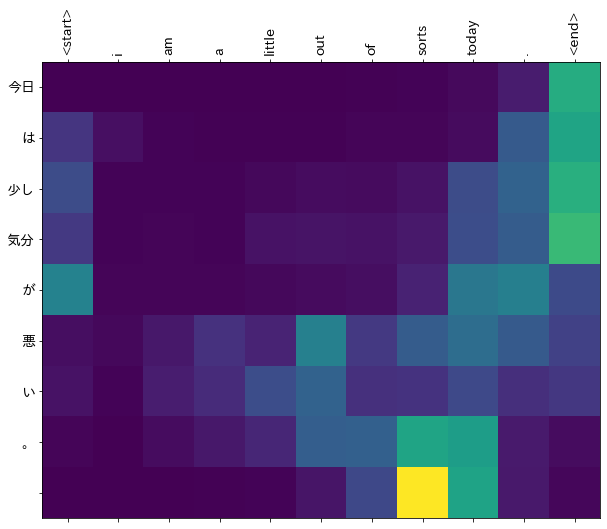

In [29]:
translate("i am a little out of sorts today .")

### テスト用データセットを使った評価

時間節約のため、テスト用データセットの先頭300件を対象として、訓練済みモデルによる翻訳を行い、正解（翻訳例）との比較を行うためのデータフレームを作成する。

In [30]:
input_sentences = load_data(os.path.join(data_dir, 'test.en'))
target_sentences = load_data(os.path.join(data_dir, 'test.ja'))

input_sentences = input_sentences[:TEST_SIZE_LIMIT]
target_sentences = target_sentences[:TEST_SIZE_LIMIT]
predicted_sentences = []

for input_en in input_sentences:
    predicted_ja, _, _ = evaluate(preprocess(input_en))
    predicted_sentences.append(''.join(predicted_ja[:-1]))

result_df = pd.DataFrame({'input_sentence': input_sentences,
                          'target_sentence': target_sentences,
                          'predicted_sentence': predicted_sentences})  


#### BLEUスコアによる評価

機械翻訳のように、テキスト生成で正解あるいはお手本となるテキストにどれだけ近い出力ができたかを評価する指標としてBLUEスコアがあります。

BLEUスコアの定義は下記の通りで、基本はN-グラム単位での一致がどれくらいあるかです。

$$
    BLEU = BP_{BLEU} \times \exp(\sum_{i=0}^Nw_n\log p_n) \\
    p_n = \frac{\sum_i翻訳文iと参照訳iで一致したn–gram数}{\sum_i翻訳文i中の全n–gram数} \\
    w_n = \frac{1}{N} \\
    BP_{BLEU} = 
        \begin{cases}
            1 \quad c \geqq r \\
            \exp(1-\frac{r}{c}) \quad c < r \\
        \end{cases} \\
        ただし、
        \begin{cases}
        c = \sum_i 翻訳文の長さ \\ 
        r = \sum_{参照訳集合} 参照訳中で対応する翻訳文に最も近い長さ \\
        \end{cases}
$$


ペナルティ $BP_{BLEU}$ は、短い翻訳文の一致度が高くなることに対する対策です。

ただし、Nが大きくなると一致度が低下し、スコアが急激に低下する問題があるため、これを平滑化する手法がいくつも提案されています。  

今回は、nltkライブラリの`nltk.translate.blue_score.sentence_bleu()`を使用して計算していますが、このライブラリでmethod4として実装されている平滑化手法を使用しています。

下記のコードでBLEU値を計算し、データフレームに列を追加しています。

In [31]:
bleu_scores = []
for row in result_df.itertuples():
    bleu_scores.append(
        sentence_bleu(row.target_sentence, row.predicted_sentence,
                      smoothing_function=SmoothingFunction().method4)
    )
result_df['bleu_score'] = bleu_scores

In [32]:
result_df

,input_sentence,target_sentence,predicted_sentence,bleu_score
0,they finally acknowledged it as true .,彼 ら は つい に それ が 真実 だ と 認め た 。,彼 ら は それ を 言 っ た 。,0.269130
1,he didn 't care for swimming .,彼 は 水泳 が 得意 で は な かっ た 。,彼 は 泳ぎ を 入れ な かっ た 。,0.243904
2,he is no less kind than his sister .,彼 は お 姉 さん に 劣 ら ず 親切 だ 。,彼 は お 姉 さん と 話 す こと は 容易 で は な い 。,0.127277
3,you must be back before ten .,１０ 時 前 に 戻 ら な けれ ば な ら な い 。,10 時 まで に 戻 る な 。,0.268659
4,break a leg .,成功 を 祈 る わ 。,い い な さ い 。,0.356676
...,...,...,...,...
295,i 'm very sleepy now .,今 とても 眠 い 。,とても 疲れ で す 。,0.399584
296,"above the music , i could hear her crying .",音楽 が な っ て い る の に 彼女 の 鳴き声 が 聞こえ た 。,その 先生 の 話 を 知 ら せ ん だ と 思 っ た の で い る,0.107584
297,we had the meeting in this room last friday .,先週 の 金曜 日 この 部屋 で 会合 が あ っ た 。,この 部屋 の 部屋 が あ り ま し た 。,0.196274
298,who do you want to speak to ?,お 話 に な る 方 の お 名前 は 。,誰 が ため に 話 し た い で す か 。,0.160257


In [33]:
result_df.bleu_score.mean()

0.1926190246410859